Let's try generating a DC-SBM properly and then do the PPR stuff again.  This way we don't have to worry about errors translating from the SBM.

10 communities w/ 100 nodes each, 1 one with 1,000

In [464]:
import numpy as np
from scipy.integrate import trapz

In [494]:
# block membership matrix
Z = np.zeros((2000, 11), dtype=int)

sizes = np.append(np.array([100]*10), 1000)
C = len(sizes)
N = sizes.sum()

thresholds = np.zeros(len(sizes) + 1, dtype=int)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

for i in range(C):
    Z[thresholds[i]:thresholds[i+1]][:,i] = 1

    
# mixing matrix
# average of 8 edges between the smaller off-diagonal classes
B = np.ones((C,C)) * 8
B[:,-1] *= 10
B[-1, :] *= 10

for i in range(C -1):
    B[i,i] = 3200
    
B[-1,-1] = 320000

# theta should sum to 1 for each block
theta = np.ones(N)
theta[:1000] *= 1e-2
theta[1000:] *= 1e-3

assert theta.sum() == C

# generate random graph
A = np.zeros((N,N), dtype=int)
rng = np.random.default_rng(7777778)
choices = rng.uniform(size=N*(N-1)//2)

# probabilities for each pair of nodes
theta = np.diag(theta)
p = (theta @ Z @ B @ Z.T @ theta)

# this sucks but yeet
A = np.zeros((N,N), dtype=int)

k = 0
for i in range(N):
    for j in range(i+1, N):
        if choices[k] < p[i,j]:
            A[i,j] = 1
            A[j,i] = 1
        k+=1

In [495]:
for i in range(C):
    print(A[thresholds[i]:thresholds[i+1]].sum() - B.sum(axis=0)[i])

88.0
-110.0
-92.0
-37.0
29.0
-12.0
-21.0
-49.0
48.0
47.0
-757.0


In [496]:
for i in range(C):
    print(
        A[thresholds[i]:thresholds[i+1], thresholds[i]:thresholds[i+1]].sum() - B[i,i])

86.0
-104.0
-102.0
-38.0
40.0
2.0
-24.0
-68.0
56.0
54.0
-746.0


In [497]:
B.sum(axis=0)

array([  3352.,   3352.,   3352.,   3352.,   3352.,   3352.,   3352.,
         3352.,   3352.,   3352., 320800.])

Ok I am satisfied.  This DC-SBM looks legit.

Compute blockwise PPR

In [498]:
# fix source node of PPR for now
u = 7
alpha = 0.3

pi = np.zeros(N)
pi[u] = 1

D = np.diag(B.sum(axis=0))
P = np.linalg.inv(D) @ B

alpha_pi_t = pi @ Z * alpha


inv_transform = np.linalg.inv(np.eye(C) - (1-alpha)*P)
p = alpha_pi_t @ inv_transform

# blockwise PPR vector
p

array([0.90456059, 0.00477533, 0.00477533, 0.00477533, 0.00477533,
       0.00477533, 0.00477533, 0.00477533, 0.00477533, 0.00477533,
       0.05246141])

In [499]:
from lassort.localassort import calculateRWRrange

# is this correct?
degree = A.sum(axis=0)
D = np.diag(1./degree, 0)
# construct transition matrix (row normalised adjacency matrix)
W = D @ A

pr = np.array([alpha])

pis, ti, it = calculateRWRrange(W, 100, pr, N)

In [500]:
ti[:100].sum()

0.0007084564687767997

In [501]:
ti[100:200].sum()

0.913508264314111

In [502]:
ti[200:300].sum()

0.0007069888864222242

In [503]:
ti[400:500].sum()

0.0011422256022391288

Ooookay...  I think this is right actually.

In [504]:
# compute expected  multiscale mixing
# egl - ar^2
ar2 = (B.sum(axis=0) / B.sum())**2

eggl = p * np.diag(B)/ B.sum(axis=0)


qmax = 1 - ar2.sum()
r_loc = (eggl.sum() - ar2.sum()) / qmax

r_loc

0.7597160126411407

In [436]:
from lassort import localAssortF
import networkx as nx

In [505]:
G = nx.convert_matrix.from_numpy_matrix(A)
E = nx.convert_matrix.to_pandas_edgelist(G).values[:,:2]


In [506]:
attr = []

for i in range(C - 1):
    attr.append(np.ones(100, dtype=int) * i)
    
attr.append(np.ones(1000, dtype=int)*10)

M = np.hstack(attr)
assortM, assortT, _ = localAssortF(E,M,pr=np.array([0.3]))
                                   
assortT

array([0.7992832 , 0.6635741 , 0.79227753, ..., 0.98362697, 0.9833658 ,
       0.96762478])

In [507]:
assortT[:1000].mean()

0.7563480046505685

This is close...

Let's try one in the big chonk

In [538]:
# fix source node of PPR for now
u = 1554
alpha = 0.3

pi = np.zeros(N)
pi[u] = 1

D = np.diag(B.sum(axis=0))
P = np.linalg.inv(D) @ B

alpha_pi_t = pi @ Z * alpha


inv_transform = np.linalg.inv(np.eye(C) - (1-alpha)*P)
p = alpha_pi_t @ inv_transform

# compute expected  multiscale mixing
# egl - ar^2
ar2 = (B.sum(axis=0) / B.sum())**2

eggl = p * np.diag(B)/ B.sum(axis=0)


qmax = 1 - ar2.sum()
r_loc = (eggl.sum() - ar2.sum()) / qmax

r_loc

0.984786876776065

In [539]:
assortT[1000:].mean()

0.9853749271956477

In [849]:
def predict_msm_block(B, theta, Z, pr):
    """
    predict multiscale mixing based on a DC-SBM
    mixing matrix
    
    Returns
    -------
    
    predM : array_like 
        C x len(pr) array of expected local assortativities for each block.
        predM[C, i] corresponds to the expected local assortativity of nodes
        in cluster C with alpha = i
    
    predT : array_like
        C x 1 array of expected multiscale assortattivities for each block.
        predT[C] is the expected multiscale assortativity for community C
    """
    D = np.diag(B.sum(axis=0))
    P = np.linalg.inv(D) @ B
    
    ar2 = (B.sum(axis=0) / B.sum())**2
    qmax = 1 - ar2.sum()
    
    predM = np.zeros((C, len(pr)))
    predT = np.zeros((C,1))

    for i in range(C):
        u = np.where(Z[:,i]==1)[0][0]
        
        for j, alpha in enumerate((1-pr)):
            pi = np.zeros(N)
            pi[u] = 1
            
            alpha_pi_t = pi @ Z * alpha
            inv_transform = np.linalg.inv(np.eye(C) - (1-alpha)*P)
            
            # p is blockwise PPR
            p = alpha_pi_t @ inv_transform
            
            # compute multiscale mixing from PPR
            eggl = p * np.diag(B)/ B.sum(axis=0)
            predM[i,j] = (eggl.sum() - ar2.sum()) / qmax
            
            
    # use the trapezoid rule to estimate predT
    delta = (pr - np.roll(pr,1))[1:]

    traps = (predM + np.roll(predM, 1))[:,1:] / 2
    predT = (traps * delta).sum(axis=1) / pr.max()
    return predM, predT
            
    
def generate_dc_sbm(B, theta, Z, seed):
    """
    generate DC-SBM for use in actual multiscale mixing model
    """
    # generate random graph
    A = np.zeros((N,N), dtype=int)
    rng = np.random.default_rng(seed)
    choices = rng.uniform(size=N*(N-1)//2)

    # probabilities for each pair of nodes
    theta = np.diag(theta)
    p = (theta @ Z @ B @ Z.T @ theta)
    assert p.max() < 1, p.max()

    # this sucks but yeet
    A = np.zeros((N,N), dtype=int)

    k = 0
    for i in range(N):
        for j in range(i+1, N):
            if choices[k] < p[i,j]:
                A[i,j] = 1
                A[j,i] = 1
            k+=1
    
    G = nx.convert_matrix.from_numpy_matrix(A)
    E = nx.convert_matrix.to_pandas_edgelist(G).values[:,:2]
    M = np.where(Z)[1]
    
    return E, M


pr = np.arange(0,1,0.1)
predM, predT = predict_msm_block(B, theta, Z, pr)
predM

array([[-1.83654688e-01, -1.58466816e-01, -1.32915435e-01,
        -1.06991068e-01, -8.06838518e-02, -5.39835129e-02,
        -2.68793456e-02,  6.39816088e-04,  2.85856259e-02,
         5.69702562e-02],
       [-1.15586721e-01, -9.73979755e-02, -7.88105888e-02,
        -5.98124611e-02, -4.03909830e-02, -2.05330061e-02,
        -2.24812167e-04,  2.05479214e-02,  4.18001575e-02,
         6.35475390e-02],
       [-2.06006948e-01, -1.78467019e-01, -1.50587183e-01,
        -1.22358793e-01, -9.37728426e-02, -6.48199504e-02,
        -3.54903344e-02, -5.77378823e-03,  2.43403453e-02,
         5.48632028e-02],
       [-1.97224446e-01, -1.70611829e-01, -1.43649308e-01,
        -1.16327917e-01, -8.86383203e-02, -6.05707949e-02,
        -3.21152043e-02, -3.26097496e-03,  2.60029315e-02,
         5.56880475e-02],
       [-1.21151617e-01, -1.02399918e-01, -8.32504106e-02,
        -6.36911988e-02, -4.37098899e-02, -2.32935642e-02,
        -2.42874506e-03,  1.88986347e-02,  4.07032681e-02,
         6.

In [723]:
a = rng.pareto(1.8,size=10)

a / a.sum()

array([0.00471829, 0.02852622, 0.02908187, 0.01604939, 0.03318097,
       0.01476923, 0.07193769, 0.02118395, 0.69429898, 0.08625342])

# Run real experiment

In [828]:
def truncated_power_law(gamma, k_0, n, rng, size=None):
    """
    Generate a sample of size *size* from a power law distribution
    with mininmum *k_0*, maximum *n*, and power *gamma*
    """
    k_0=np.float64(k_0)
    gamma=np.float64(gamma)
    n=np.float64(n)
    
    if size:
        U = rng.uniform(size=size)
    else:
        U = rng.uniform()
        
    return (
        (k_0**(1-gamma) - 
             ( k_0**(1-gamma) - n**(1-gamma) ) * U 
        )**(1/(1-gamma))
    )


def powerlaw_partition(gamma, k_0, C, N, rng):
    sizes = truncated_power_law(gamma,k_0,N/2,rng,size=C)
    sizes = (N * sizes / sizes.sum()).astype(int) 
    
    # adjust for any count lost in rounding
    diff = N - sizes.sum()
    sizes[0] += diff
    
    return sizes

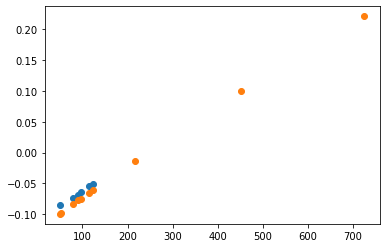

In [880]:
N = 2000
C = 10
gamma = 2.5
k_0 = 8

# Z is block membership matrix
Z = np.zeros((N, C), dtype=int)

sizes = powerlaw_partition(gamma, k_0, C, N, rng)

thresholds = np.zeros(len(sizes) + 1, dtype=int)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

for i in range(C):
    Z[thresholds[i]:thresholds[i+1]][:,i] = 1
    
# mixing matrix
B = np.ones((C,C)) * 8


for i in range(C):
    # 16% of possible internal edges exist in each class
    B[i,i] = 0.08 * sizes[i] * (sizes[i] - 1)
    
    for j in range(i+1, C):
        # 5% of possible external edges exist
        B[i,j] = 0.05 * sizes[i] * sizes[j]
        B[j,i] = B[i,j]
        
# degree distribution
# assign edge wealth to each node
theta = []

for size in sizes:
    s = rng.uniform(size=size)
    theta.append(s/s.sum())
    
theta = np.hstack(theta)
assert theta.sum() == C

# predict values
pr = np.arange(0,1,0.1)
predM, predT = predict_msm_block(B, theta, Z, pr)

# generate actual network and calculate MSM

E, M = generate_dc_sbm(B, theta, Z, 24681012)
assortM, assortT, _ = localAssortF(E,M)

y = []

for i in range(C):
    y.append(assortT[thresholds[i]:thresholds[i+1]].mean())

plt.scatter(Z.sum(axis=0),y)
plt.scatter(Z.sum(axis=0),predT)

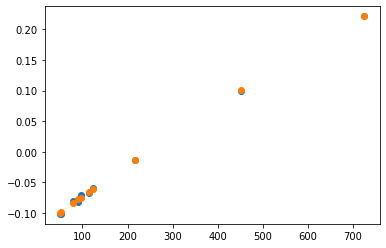

In [881]:
# generate actual network and calculate MSM

E, M = generate_dc_sbm(B, theta, Z, 333)
assortM, assortT, _ = localAssortF(E,M)

y = []

for i in range(C):
    y.append(assortT[thresholds[i]:thresholds[i+1]].mean())

plt.scatter(Z.sum(axis=0),y)
plt.scatter(Z.sum(axis=0),predT)

9
9
9
9
9
9
9
9
9
9


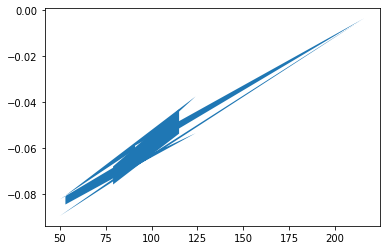

In [892]:
n_trials = 10

mMax = np.ones(C) * -np.inf
mMin = np.ones(C) * np.inf

for j in range(n_trials):
    seed = j
    E, M = generate_dc_sbm(B, theta, Z, seed)
    assortM, assortT, _ = localAssortF(E,M)

    for i in range(C):
        msm = assortT[thresholds[i]:thresholds[i+1]].mean()
        if msm > mMax[i]:
            mMax[i] = msm
        if msm < mMin[i]:
            mMin[i] = msm

        
plt.fill_between(Z.sum(axis=0), mMin, mMax)

In [936]:
Z.sum(axis=0)

array([725,  91, 216,  50,  96, 124,  53, 451,  79, 115])

In [918]:
np.where(E==733)

(array([], dtype=int64), array([], dtype=int64))

In [928]:
assortT
assortT[thresholds[i]:thresholds[i+1]].mean()

-0.05673542073412896

In [932]:
com = assortT[thresholds[i]:thresholds[i+1]]
com[np.where(~np.isnan(com))].mean()

-0.05673542073412896

In [934]:
y = np.zeros(C)

for i in range(C):
    com = assortT[thresholds[i]:thresholds[i+1]]
    msm = com[np.where(~np.isnan(com))].mean()
    if msm > mMax[i]:
        mMax[i] = msm
    if msm < mMin[i]:
        mMin[i] = msm
        
    y[i] = msm
    
y

array([ 0.21174114, -0.06486218, -0.0017703 , -0.08419445, -0.05673542,
       -0.04503654, -0.08121559,  0.10070097, -0.06504273, -0.05305161])

In [924]:
assortT

array([ 0.0933832 ,  0.19114726,  0.22441911, ..., -0.04188586,
       -0.03773417, -0.09606901])

In [937]:
sizes.sort()
sizes

array([ 50,  53,  79,  91,  96, 115, 124, 216, 451, 725])

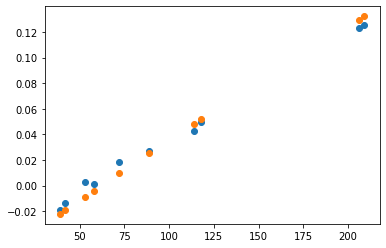

In [939]:
N = 1000
C = 10
gamma = 2.5

# block membership matrix
Z = np.zeros((N, C), dtype=int)

sizes = powerlaw_partition(gamma, 8, C, N, rng)
sizes.sort()

thresholds = np.zeros(len(sizes) + 1, dtype=int)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

for i in range(C):
    Z[thresholds[i]:thresholds[i+1]][:,i] = 1
    
# mixing matrix
B = np.ones((C,C)) * 8


for i in range(C):
    # 16% of possible internal edges exist in each class
    B[i,i] = 0.08 * sizes[i] * (sizes[i] - 1)
    
    for j in range(i+1, C):
        # 5% of possible external edges exist
        B[i,j] = 0.05 * sizes[i] * sizes[j]
        B[j,i] = B[i,j]
        
# degree distribution
# assign edge wealth to each node
theta = []

for size in sizes:
    s = rng.uniform(size=size)
    theta.append(s/s.sum())
    
theta = np.hstack(theta)
assert theta.sum() == C

# predict values
pr = np.arange(0,1,0.1)
predM, predT = predict_msm_block(B, theta, Z, pr)

# generate actual network and calculate MSM
E, M = generate_dc_sbm(B, theta, Z, 24681012)
assortM, assortT, _ = localAssortF(E,M)

y = []

for i in range(C):
    com = assortT[thresholds[i]:thresholds[i+1]]
    y.append(com[np.where(~np.isnan(com))].mean())

plt.scatter(Z.sum(axis=0),y)
plt.scatter(Z.sum(axis=0),predT)

0
1
2
3
4
5
6
7
8
9


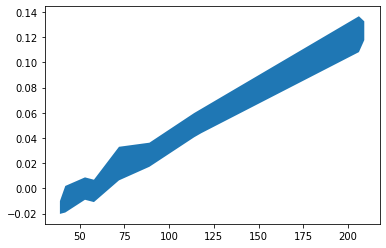

In [941]:
n_trials = 10

mMax = np.ones(C) * -np.inf
mMin = np.ones(C) * np.inf

for j in range(n_trials):
    seed = j
    E, M = generate_dc_sbm(B, theta, Z, seed)
    assortM, assortT, _ = localAssortF(E,M)

    for i in range(C):
        com = assortT[thresholds[i]:thresholds[i+1]]
        msm = com[np.where(~np.isnan(com))].mean()
        
        if msm > mMax[i]:
            mMax[i] = msm
        if msm < mMin[i]:
            mMin[i] = msm
            
    print(j)

        
plt.fill_between(Z.sum(axis=0), mMin, mMax)

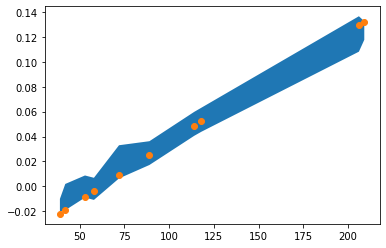

In [942]:
plt.fill_between(Z.sum(axis=0), mMin, mMax)
plt.scatter(Z.sum(axis=0),predT)

<ErrorbarContainer object of 3 artists>

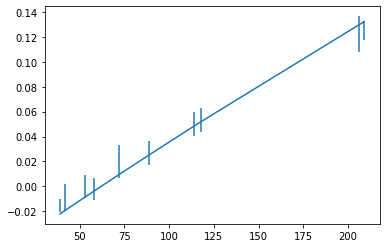

In [948]:
lower = predT - mMin
upper = mMax - predT

yerr = np.vstack([low, up])

plt.errorbar(Z.sum(axis=0),predT, yerr=yerr)

<ErrorbarContainer object of 3 artists>

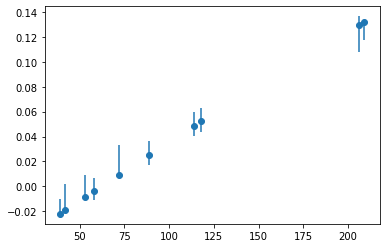

In [952]:
plt.errorbar(Z.sum(axis=0),predT, yerr=yerr, fmt="o")

In [954]:
N = 1000
C = 10
gamma = 2.5
n_trials = 10


# block membership matrix
Z = np.zeros((N, C), dtype=int)

sizes = powerlaw_partition(gamma, 8, C, N, rng)
sizes.sort()

thresholds = np.zeros(len(sizes) + 1, dtype=int)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

for i in range(C):
    Z[thresholds[i]:thresholds[i+1]][:,i] = 1
    
# mixing matrix
B = np.ones((C,C)) * 8


for i in range(C):
    # 16% of possible internal edges exist in each class
    B[i,i] = 0.08 * sizes[i] * (sizes[i] - 1)
    
    for j in range(i+1, C):
        # 5% of possible external edges exist
        B[i,j] = 0.05 * sizes[i] * sizes[j]
        B[j,i] = B[i,j]
        
# degree distribution
# assign edge wealth to each node
theta = []

for size in sizes:
    s = rng.uniform(size=size)
    theta.append(s/s.sum())
    
theta = np.hstack(theta)
assert theta.sum() == C

# predict values
pr = np.arange(0,1,0.1)
predM, predT = predict_msm_block(B, theta, Z, pr)

batches = []

for j in range(n_trials):
    seed = j
    
    # generate graph
    # this can fail if a probability is > 1
    for k in range(5):
        try:
            E, M = generate_dc_sbm(B, theta, Z, seed)
            break
        except:
            continue
    
    assortM, assortT, _ = localAssortF(E,M)

    scores = []
    for i in range(C):
        com = assortT[thresholds[i]:thresholds[i+1]]
        msm = com[np.where(~np.isnan(com))].mean()
        scores.append(msm) 
    
    batches.append(scores)
    print(j)

/Users/rebecca/school/csci5352/Project/MultiscaleMixing/source/lassort/localassort.py:62: RuntimeWarning: divide by zero encountered in true_divide
  D = sparse.diags(1./degree, 0, format='csc')
/Users/rebecca/school/csci5352/Project/MultiscaleMixing/source/lassort/localassort.py:74: RuntimeWarning: invalid value encountered in true_divide
  Z = (W @ Z) / degree
/Users/rebecca/school/csci5352/Project/MultiscaleMixing/source/lassort/localassort.py:121: RuntimeWarning: invalid value encountered in true_divide
  e_gh /= e_gh_sum


0
1
2
3
4
5
6
7
8
9


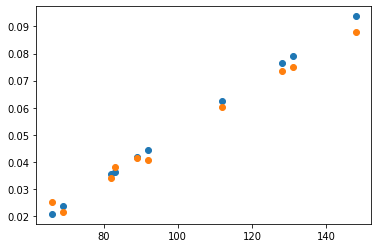

In [961]:
plt.scatter(Z.sum(axis=0),predT)
plt.scatter(Z.sum(axis=0),np.array(batches).mean(axis=0))

In [964]:
y = np.array(batches)
y.std(axis=0)

array([0.0069924 , 0.00490956, 0.00402412, 0.0070274 , 0.00570761,
       0.00329611, 0.00501495, 0.0059688 , 0.00524931, 0.00314476])

Text(0.5, 1.0, 'N=1000, 10 trials')

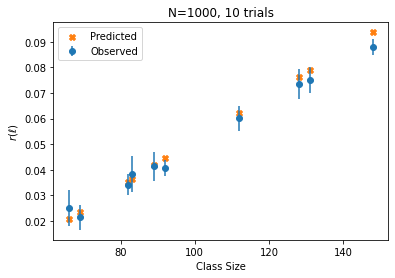

In [984]:
plt.scatter(Z.sum(axis=0),predT,marker="X",color="tab:orange")

plt.errorbar(
    Z.sum(axis=0), 
    y.mean(axis=0),
    y.std(axis=0),
    fmt="o"
)

plt.legend(["Predicted", "Observed"])
plt.xlabel("Class Size")
plt.ylabel("$r(\ell)$")
plt.title(f"N={N}, {n_trials} trials")

In [991]:
rng.choice(1000)

38